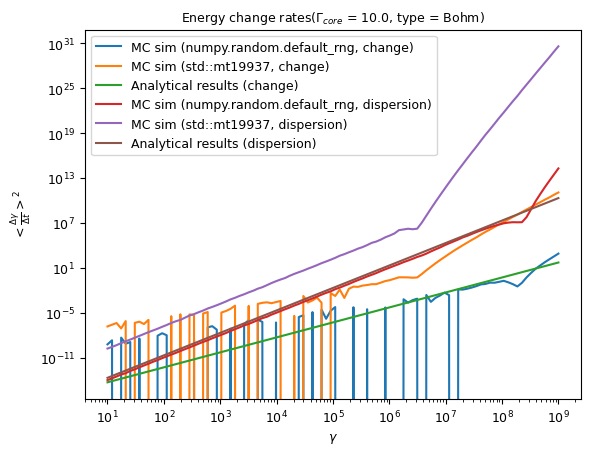

[6.328114687107096e-10, 2.208231609222565e-09, -4.599275805435261e-09, 5.0436343270573694e-09, 7.658698378217311e-10, 1.2934123439925978e-09, -1.9964854086821698e-09, 3.811856580509183e-09, -1.5057350008159163e-08, -2.6298894143282457e-09, -1.2534090588659123e-08, 9.024556253377686e-09, 1.944127298104753e-08, 1.037424653298969e-08, -2.07729702072521e-08, -4.905904063994191e-08, -9.092866079838581e-08, -2.110356098711547e-08, -3.5734002704388094e-08, 2.677597021041462e-09, -1.470114939511689e-07, -1.8420458330036905e-07, 1.1672388750549629e-07, 1.7031225187248108e-07, 5.7779893403674086e-08, -1.0289384837753971e-07, -1.3529202553430505e-07, 7.782261595575226e-08, -1.4575002931640195e-07, -1.832254390337276e-08, 2.924981630210516e-07, 1.107952099434359e-06, -1.2041873590382438e-06, 1.246913214824599e-06, 6.295255074131964e-07, -3.062552253007303e-07, -2.5358045733117288e-06, 5.294514896699814e-07, -5.826268963223994e-06, -5.960546538256454e-07, -1.9995398269731455e-06, -5.62135624950678e

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import astropy.constants as const

with open('/home/wsy/Acc_MC/MC_sim/paras.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
pi = np.pi
c = (const.c.cgs).value
m_p = (const.m_p.cgs).value
m_e = (const.m_e.cgs).value
e = (const.e.esu).value
    
R_sh = float(config['R_sh'])
GM0 = float(config['GM0'])
eta = float(config['eta'])
beta_min = float(config['beta_min'])
B0 = float(config['B0'])
xi = float(config['xi'])
Lam_max = float(config['Lam_max'])
g_me0 = float(config['g_me0']) 
r0 = float(config['r0'])
n_p = float(config['n_p'])

N_par = int(config['N_par']) # 粒子数
N_time = int(float((config['N_time']))) # 时间步数
N_bins = int(config['N_bins']) # 时间步长

jet_type = str(config['type'])
syn = bool(config['SYN_flag'])
SA = bool(config['SA_flag'])
Sh = bool(config['Shear_flag'])
ESC = bool(config['ESC_flag'])

if jet_type=='kolgv': 
    q = 5/3
elif jet_type=='Bohm':
    q = 1
elif jet_type=='HS':
    q = 2
else:
    raise ValueError("The input should be meaningful")


def beta_dis(r):
    beta_max = np.sqrt(1-1/GM0**2)
    r1 = eta*R_sh
    if (r < r1):
        return beta_max
    elif (r > R_sh):
        return 0.0
    else: 
        return beta_max-((beta_max-beta_min)/(R_sh-r1))*(r-r1)
    
def Rg_calc(g_me):
    return np.sqrt(g_me**2)*m_e*c**2/(e*B0)


def tau_calc(g_me):
    return Rg_calc(g_me)**(2-q)*Lam_max**(q-1)*(c*xi)**(-1)

def T_sh(B0,gme):
    beta0 = beta_dis(0) #中心流速
    beta = beta_dis(r0) #注入位置流速
    rate = 1- eta # 剪切区域比例
    Delta_r = rate*R_sh
    A_sc = xi**(-1)*Lam_max**(q-1)*c**(-1)*(m_e*np.square(c)/(e*B0))**(2-q)
    Gamma_j4 = 1/(1-beta**2)**2
    A1=(2/15)*Gamma_j4*np.square(c*(beta0/Delta_r))*A_sc
    t_sh = 2*gme**(q-2)/(A1*(6-q))
    return t_sh

def Dispr_gamma(gme):
    beta0 = beta_dis(0) #中心流速
    beta = beta_dis(r0) #注入位置流速
    rate = 1- eta # 剪切区域比例
    Gamma_j4 = 1/(1-beta**2)**2
    Delta_r = rate*R_sh
    res = (2/15)*Gamma_j4*np.square(c*(beta0/Delta_r))*gme**2*tau_calc(gme)
    return res
    
ba = B0 / np.sqrt(B0**2 + 4 * pi * n_p * m_p * c**2)  # 无量纲Alfven波速

nan = np.nan
tar_dir = '/home/wsy/Acc_MC/MC_sim/codes/Code_Trials/Results/'
gammas = np.load(tar_dir + 'Gammas.npy')
#print(gammas)
gmes = np.logspace(1,9, 100)
tau = tau_calc(gmes)
ave_list1 = []
ave_list2 = []
for i in range(len(gammas[0,:])):
    mean_rate = np.mean((gammas[:,i]-gmes[i])/tau[i])
    #print(gmes[i])
    ave_list1.append(mean_rate)

for j in range(len(gammas[0,:])):
    mean_rate2 = np.mean((gammas[:,j]-gmes[j])**2/tau[j])
    ave_list2.append(mean_rate2)
    
t_sh = T_sh(B0,gmes)
rates = gmes/t_sh
disps = Dispr_gamma(gmes)


dgammas_c = np.loadtxt('/home/wsy/Acc_MC/MC_sim/codes/Code_Trials/cpp_random/Gammas.txt')
x_c = np.loadtxt('/home/wsy/Acc_MC/MC_sim/codes/Code_Trials/cpp_random/gmes.txt')
tau_c = tau_calc(x_c)
ave_list1_c = []
ave_list2_c = []
for i in range(len(dgammas_c[0,:])):
    mean_rate = np.mean((dgammas_c[:, i])/tau_c[i])
    #print(gmes[i])
    ave_list1_c.append(mean_rate)

for j in range(len(dgammas_c[0,:])):
    mean_rate2 = np.mean((dgammas_c[:, j])**2/tau_c[j])
    ave_list2_c.append(mean_rate2)
    
#print(ave_list)

plt.rcParams.update({
    'axes.titlesize': 9,          # 轴标题
    'axes.labelsize': 9,          # 轴标签
    'xtick.labelsize': 9,         # x轴刻度
    'ytick.labelsize': 9,         # y轴刻度
    'legend.fontsize': 9,         # 图例
    'figure.titlesize': 9         # 图形标题
})

plt.plot(gmes, ave_list1, label = 'MC sim (numpy.random.default_rng, change)')
plt.plot(x_c, ave_list1_c, label = 'MC sim (std::mt19937, change)')
plt.plot(gmes, rates, label = 'Analytical results (change)')
plt.plot(gmes, ave_list2, label = 'MC sim (numpy.random.default_rng, dispersion)')
plt.plot(gmes, ave_list2_c, label = 'MC sim (std::mt19937, dispersion)')
plt.plot(gmes, disps, label = 'Analytical results (dispersion)')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Energy change rates($\Gamma_{core}$ = %s, type = %s)'%(GM0,jet_type))
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$<\frac{\Delta \gamma}{\Delta t}>^2$')
plt.legend()
plt.show()

print(ave_list1)
print(gmes)


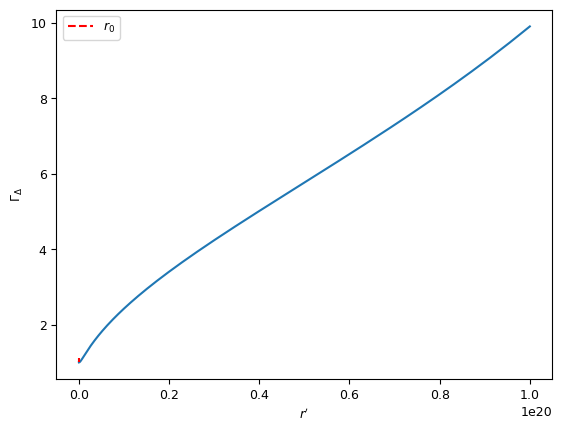

In [191]:
beta0 = beta_dis(r0)
betas = []
r = np.logspace(0,20,1000)
for rs in r:
    betas.append(beta_dis(rs))
betas =np.array(betas)
dbeta = (betas-beta0)/(1-betas*beta0)
Gamma_delt = 1/(np.sqrt(1-dbeta**2))
plt.plot(r, Gamma_delt) #label = r'$\Gamma_{\Delta}$'
plt.vlines(r0, 1.0, 1.11, label = r'$r_0$', linestyles='--', colors='r')
#plt.xscale('log')
plt.xlabel(r'$r^{\prime}$')
plt.ylabel(r'$\Gamma_{\Delta}$')
plt.legend()
plt.show()

[-4.78024721e-08  3.49600198e-08 -9.98857664e-09 -4.99428834e-09
 -5.35102296e-08  2.14040935e-08 -7.84816737e-09  3.42465500e-08
 -2.14040930e-09  1.07020466e-08  2.06906237e-08 -3.21061385e-08
 -4.63755327e-08 -2.71118504e-08  4.13812482e-08  4.49485973e-08
  2.63983821e-08  3.78138991e-08  1.28424560e-08  4.56620672e-08
 -5.13698206e-08 -2.14040925e-08  9.27510705e-09  4.35216577e-08
  7.13469767e-10 -3.42465476e-08 -5.27967600e-08  1.21289862e-08
  5.13698258e-08 -2.78253201e-08  5.42237052e-08 -2.35445018e-08
  3.78138991e-08  5.70775817e-09  5.06563560e-08 -3.92408356e-08
 -1.92636833e-08 -7.13469762e-09  4.56620672e-08  3.85273689e-08
 -1.35559254e-08 -1.21289859e-08  7.13469772e-09  3.92408387e-08
  5.13698258e-08 -4.63755327e-08 -1.71232741e-08  4.42351275e-08
  3.99543085e-08 -2.42579715e-08 -1.14155161e-08 -3.63869568e-08
 -1.71232741e-08 -7.84816737e-09  1.78367445e-08  2.14040931e-09
 -1.64098044e-08  1.99771539e-08  5.35102354e-08  4.63755370e-08
  3.13926707e-08  1.14155

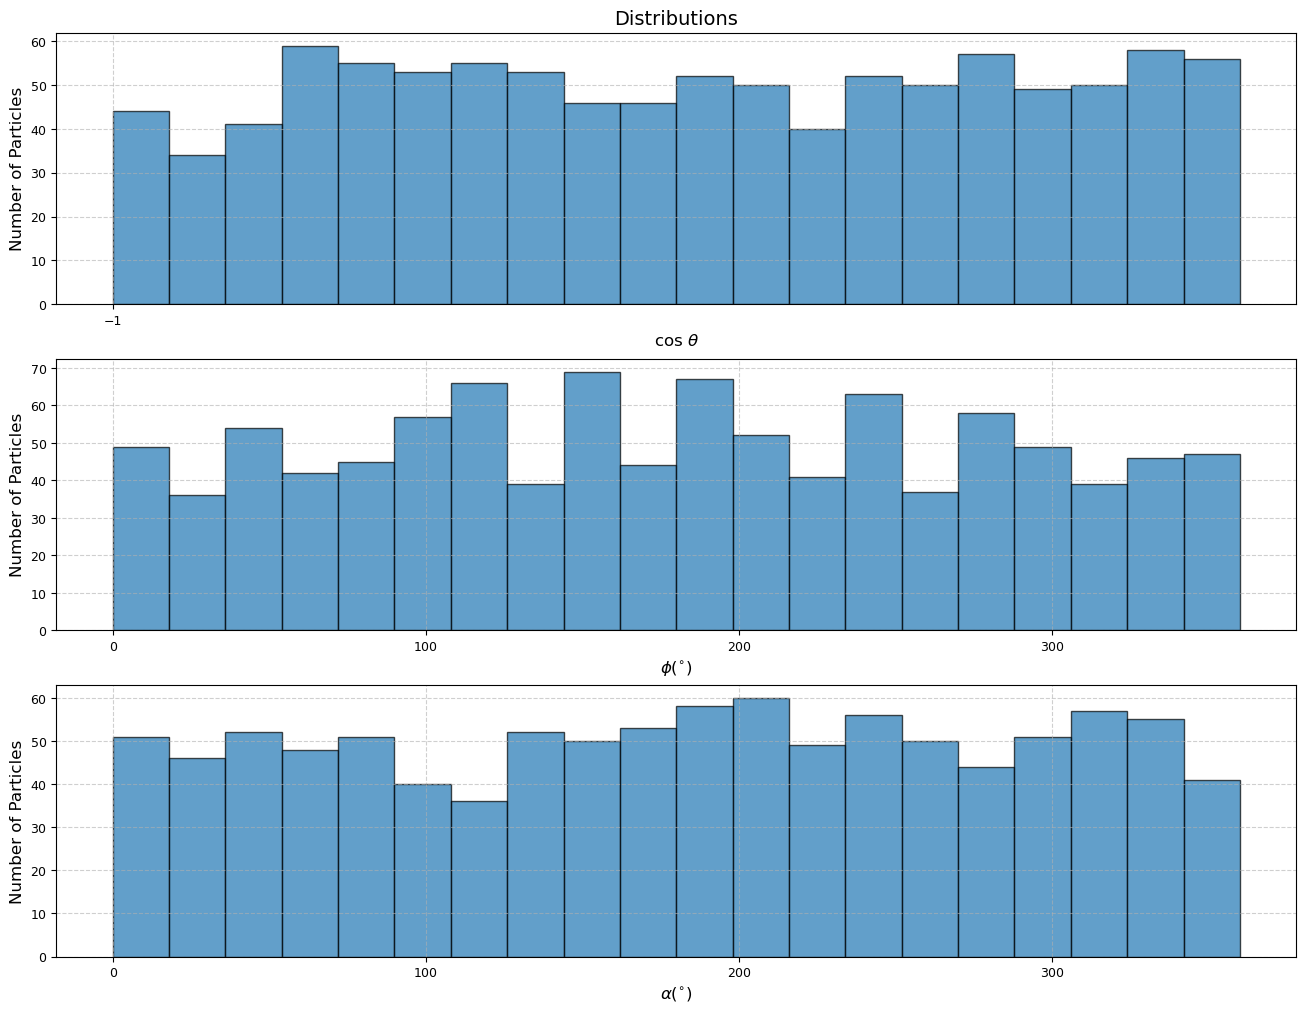

In [192]:
idx = 0
costhetas = np.load(tar_dir + 'Coses.npy')
cos1 = costhetas[:,idx]
thetas = cos1

phis_pros = np.load(tar_dir + 'Phis.npy')
phi1 = phis_pros[:,idx]
phis = np.degrees(phi1)

alphas_pros = np.load(tar_dir + 'Alphas.npy')
alpha1 = alphas_pros[:,idx]
alphas = np.degrees(alpha1)

beta_Ds = np.load(tar_dir + 'beta_D.npy')
beta_D1 = beta_Ds[:,idx]
print(beta_D1)


# 绘制直方图
fig = plt.figure(figsize = (16,12))
ax1 = fig.add_subplot(311)
n, bins, patches = plt.hist(thetas, 
                            bins=20, 
                            range=(-1, 1), 
                            edgecolor='black', 
                            alpha=0.7,
                            color='#1f77b4')
ax1.set_title('Distributions', fontsize=14)
ax1.set_xlabel(r'cos $\theta$', fontsize=12)
ax1.set_ylabel('Number of Particles', fontsize=12)
ax1.set_xticks(np.arange(-1, 1, 100)) 
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = fig.add_subplot(312)
n, bins, patches = plt.hist(phis, 
                            bins=20, 
                            range=(0,360), 
                            edgecolor='black', 
                            alpha=0.7,
                            color='#1f77b4')
#ax2.set_title(r'$\phi$ Distribution', fontsize=14)
ax2.set_xlabel(r'$\phi(^{\circ})$', fontsize=12)
ax2.set_ylabel('Number of Particles', fontsize=12)
ax2.set_xticks(np.arange(0, 360, 100)) 
ax2.grid(True, linestyle='--', alpha=0.6)

ax3 = fig.add_subplot(313)
n, bins, patches = plt.hist(alphas, 
                            bins=20, 
                            range=(0,360), 
                            edgecolor='black', 
                            alpha=0.7,
                            color='#1f77b4')
#ax3.set_title(r'$\alpha$ Distribution', fontsize=14)
ax3.set_xlabel(r'$\alpha(^{\circ})$', fontsize=12)
ax3.set_ylabel('Number of Particles', fontsize=12)
ax3.set_xticks(np.arange(0, 360, 100)) 
ax3.grid(True, linestyle='--', alpha=0.6)
plt.show()

/home/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


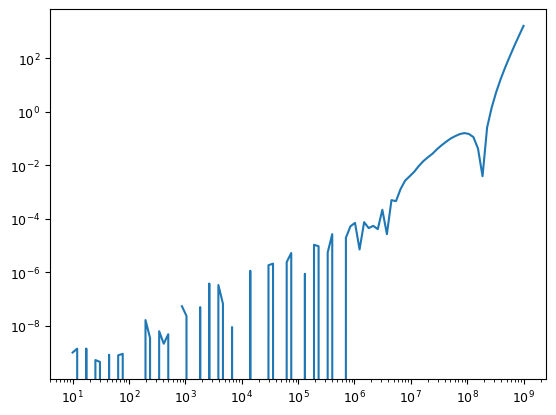

In [193]:
# 单方向分布
costhetas = np.load(tar_dir + 'Coses.npy')
gammas = np.load(tar_dir + 'Gammas.npy')
cos_min = -0.01
cos_max = 0
lists = []
for i in range(len(gammas[0,:])):
    cos1 = costhetas[:,i]
    mask1 = (cos1 >= cos_min) & (cos1 <= cos_max)
    gammas_i = gammas[mask1,i]
    delta_gm = np.mean((gammas_i - gmes[i])/tau[i])
    lists.append(delta_gm)
    
plt.plot(gmes,lists)
plt.yscale('log')
plt.xscale('log')
plt.show()

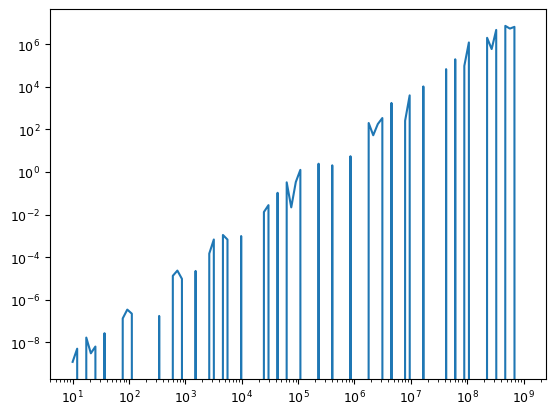

[6.328114687107096e-10, 2.208231609222565e-09, -4.599275805435261e-09, 5.0436343270573694e-09, 7.658698378217311e-10, 1.2934123439925978e-09, -1.9964854086821698e-09, 3.811856580509183e-09, -1.5057350008159163e-08, -2.6298894143282457e-09, -1.2534090588659123e-08, 9.024556253377686e-09, 1.944127298104753e-08, 1.037424653298969e-08, -2.07729702072521e-08, -4.905904063994191e-08, -9.092866079838581e-08, -2.110356098711547e-08, -3.5734002704388094e-08, 2.677597021041462e-09, -1.470114939511689e-07, -1.8420458330036905e-07, 1.1672388750549629e-07, 1.7031225187248108e-07, 5.7779893403674086e-08, -1.0289384837753971e-07, -1.3529202553430505e-07, 7.782261595575226e-08, -1.4575002931640195e-07, -1.832254390337276e-08, 2.924981630210516e-07, 1.107952099434359e-06, -1.2041873590382438e-06, 1.246913214824599e-06, 6.295255074131964e-07, -3.062552253007303e-07, -2.5358045733117288e-06, 5.294514896699814e-07, -5.826268963223994e-06, -5.960546538256454e-07, -1.9995398269731455e-06, -5.62135624950678e

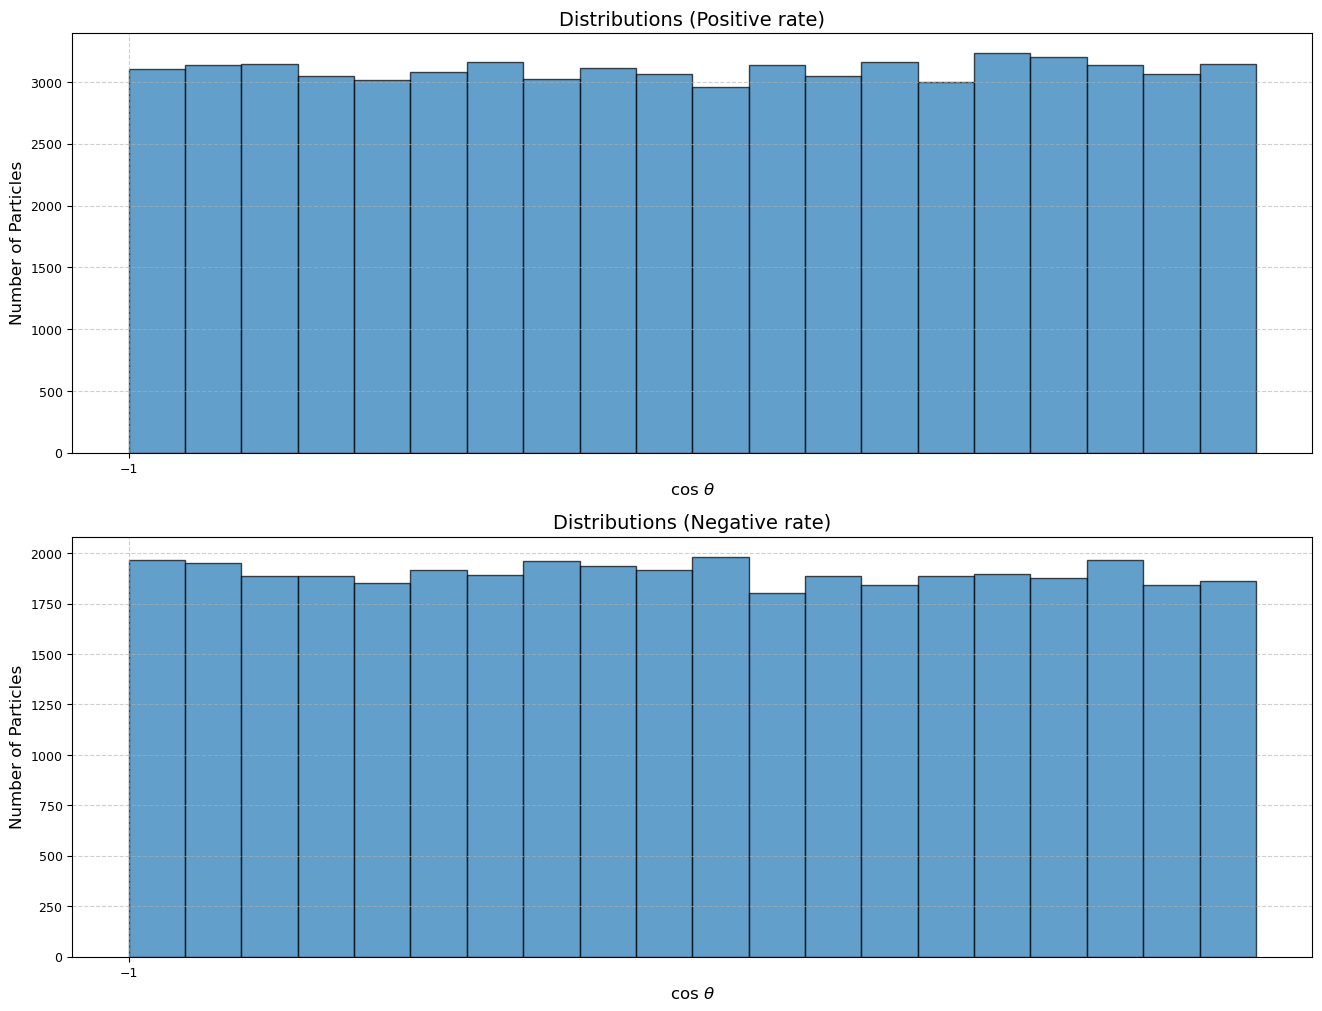

In [194]:
lists = []
for i in range(len(gammas[0,:])):
    cos1 = costhetas[:,i]
    beta_D = beta_Ds[:,i]
    delta_gm = np.mean(-gmes[i]*cos1*beta_D)
    lists.append(delta_gm)
    
plt.plot(gmes,lists)
plt.yscale('log')
plt.xscale('log')
plt.show()
#print(lists)

print(ave_list1)
pos_idx = np.where(np.array(ave_list1)>0)[0] # 正增长值序列的序号
neg_idx = np.where(np.array(ave_list1)<=0)[0] # 负增长值索引
print(pos_idx)
print(neg_idx)


costhetas_neg = costhetas[:,neg_idx].flatten()
costhetas_pos = costhetas[:,pos_idx].flatten()

fig = plt.figure(figsize = (16,12))
ax1 = fig.add_subplot(211)
n, bins, patches = plt.hist(costhetas_pos, 
                            bins=20, 
                            range=(-1, 1), 
                            edgecolor='black', 
                            alpha=0.7,
                            color='#1f77b4')
ax1.set_title('Distributions (Positive rate)', fontsize=14)
ax1.set_xlabel(r'cos $\theta$', fontsize=12)
ax1.set_ylabel('Number of Particles', fontsize=12)
ax1.set_xticks(np.arange(-1, 1, 100)) 
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = fig.add_subplot(212)
n, bins, patches = plt.hist(costhetas_neg, 
                            bins=20, 
                            range=(-1, 1), 
                            edgecolor='black', 
                            alpha=0.7,
                            color='#1f77b4')
ax2.set_title('Distributions (Negative rate)', fontsize=14)
ax2.set_xlabel(r'cos $\theta$', fontsize=12)
ax2.set_ylabel('Number of Particles', fontsize=12)
ax2.set_xticks(np.arange(-1, 1, 100)) 
ax2.grid(True, linestyle='--', alpha=0.6)


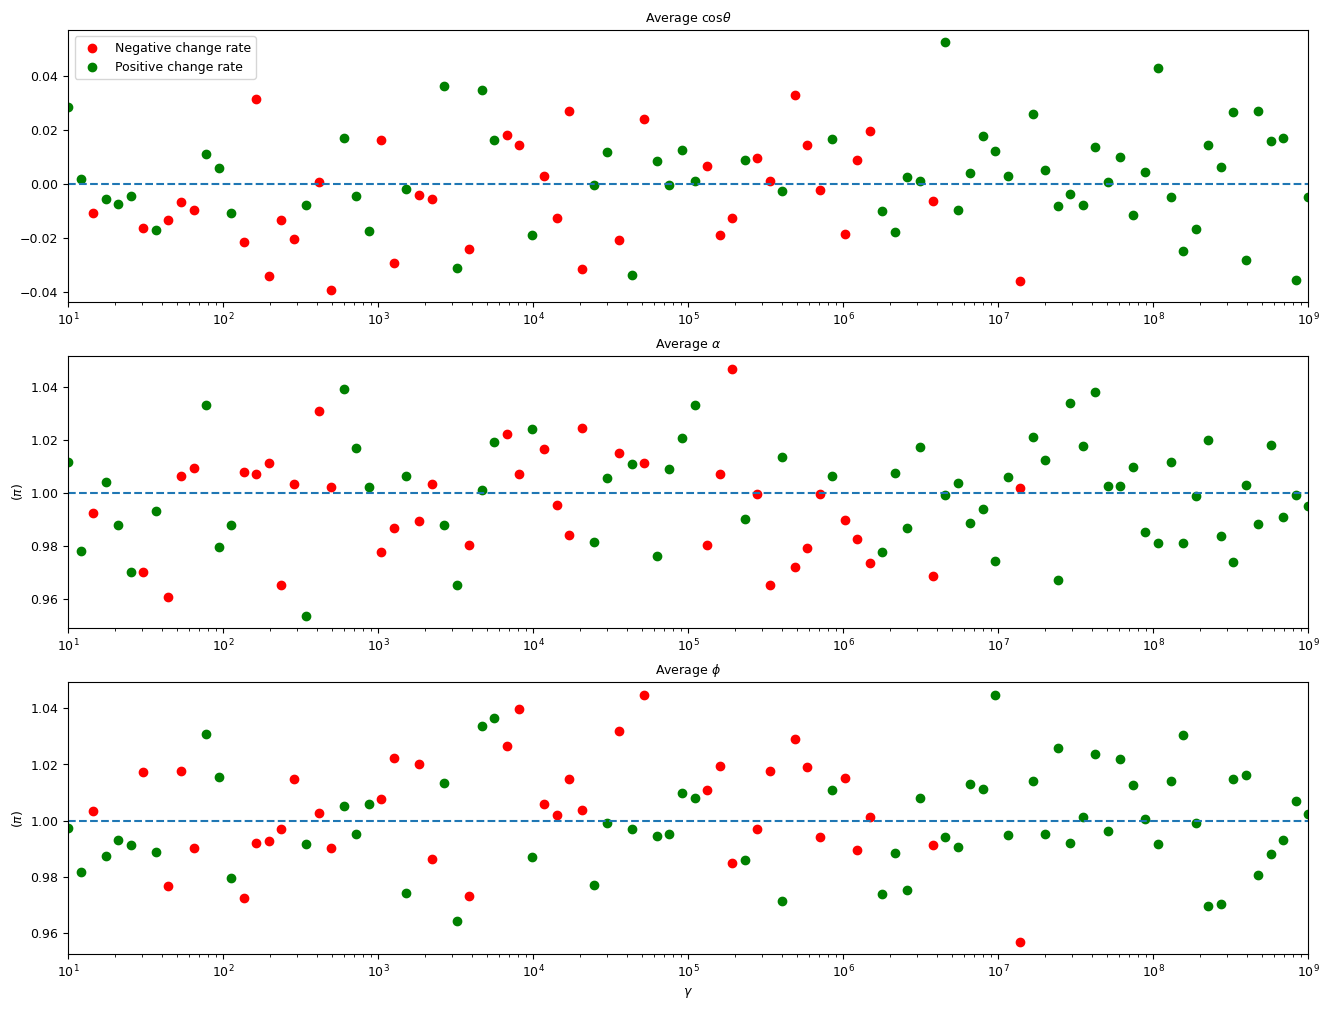

In [195]:
costheta_idx1 = []
costheta_idx2 = []
alphas_idx1 = []
alphas_idx2 = []
phis_idx1 = []
phis_idx2 = []

# 将正值与负值对应的能量分开
gmes_neg = gmes[neg_idx]
gmes_pos = gmes[pos_idx]

# 区分天顶角
costhetas_neg = costhetas[:,neg_idx]
costhetas_pos = costhetas[:,pos_idx]

# 区分初始方位角
alphas_neg = alphas_pros[:,neg_idx]
alphas_pos = alphas_pros[:,pos_idx]

# 区分移动方位角
phis_neg = phis_pros[:,neg_idx]
phis_pos = phis_pros[:,pos_idx]

# 区分最终能量
gammas_neg = gammas[:,neg_idx]
gammas_pos = gammas[:,pos_idx]

# 区分dbeta
dbeta_neg = beta_Ds[:,neg_idx]
dbeta_pos = beta_Ds[:,pos_idx]
'''
for i in range(len(gmes_neg)):
    print(np.mean(gammas_neg[:,i]-gmes_neg[i]))
'''
fig = plt.figure(figsize = (16,12))
ax1 = fig.add_subplot(311)
for idx1 in range(len(costhetas_neg[0,:])):
    gme0 = gmes_neg[idx1]
    costhetas_idx = costhetas_neg[:,idx1]
    costheta_idx1.append(np.mean(costhetas_idx))
    #alphas_idx = alphas_neg[:,idx1]
    #phis_idx = phis_neg[:,idx1]
ax1.scatter(gmes_neg, costheta_idx1,color = 'r', label = 'Negative change rate')
for idx2 in range(len(costhetas_pos[0,:])):
    gme0 = gmes_pos[idx2]
    costhetas_idx = costhetas_pos[:,idx2]
    costheta_idx2.append(np.mean(costhetas_idx))
    #alphas_idx = alphas_pos[:,idx1]
    #phis_idx = phis_pos[:,idx1]
ax1.scatter(gmes_pos, costheta_idx2 ,color = 'g', label = 'Positive change rate')
ax1.hlines(0.0,1e1,1e9, linestyles='--')
ax1.set_xlim(1e1,1e9)
ax1.set_xscale('log')
ax1.set_title(r'Average cos$\theta$')
#ax1.set_xlabel(r'$\gamma$')
ax1.legend()

ax2 = fig.add_subplot(312)
for idx1 in range(len(costhetas_neg[0,:])):
    gme0 = gmes_neg[idx1]
    alphas_idx = alphas_neg[:,idx1]
    alphas_idx1.append(np.mean(alphas_idx/np.pi))
    #alphas_idx = alphas_neg[:,idx1]
    #phis_idx = phis_neg[:,idx1]
ax2.scatter(gmes_neg, alphas_idx1,color = 'r', label = 'Negative change rate')
for idx2 in range(len(costhetas_pos[0,:])):
    gme0 = gmes_pos[idx2]
    alphas_idx = alphas_pos[:,idx2]
    alphas_idx2.append(np.mean(alphas_idx/np.pi))
    #alphas_idx = alphas_pos[:,idx1]
    #phis_idx = phis_pos[:,idx1]
ax2.scatter(gmes_pos, alphas_idx2 ,color = 'g', label = 'Positive change rate')
ax2.hlines(1.0,1e1,1e9, linestyles='--')
ax2.set_xlim(1e1,1e9)
ax2.set_xscale('log')
ax2.set_title(r'Average $\alpha$')
#ax2.set_xlabel(r'$\gamma$')
ax2.set_ylabel(r'$(\pi)$')
#ax2.legend()


ax3 = fig.add_subplot(313)
for idx1 in range(len(costhetas_neg[0,:])):
    gme0 = gmes_neg[idx1]
    phis_idx = phis_neg[:,idx1]
    phis_idx1.append(np.mean(phis_idx/np.pi))
    #alphas_idx = alphas_neg[:,idx1]
    #phis_idx = phis_neg[:,idx1]
ax3.scatter(gmes_neg, phis_idx1,color = 'r', label = 'Negative change rate')
for idx2 in range(len(costhetas_pos[0,:])):
    gme0 = gmes_pos[idx2]
    phis_idx = phis_pos[:,idx2]
    phis_idx2.append(np.mean(phis_idx/np.pi))
    #alphas_idx = alphas_pos[:,idx1]
    #phis_idx = phis_pos[:,idx1]
ax3.scatter(gmes_pos, phis_idx2 ,color = 'g', label = 'Positive change rate')
ax3.hlines(1.0,1e1,1e9, linestyle='--')
ax3.set_xlim(1e1,1e9)
ax3.set_xscale('log')
ax3.set_title(r'Average $\phi$')
ax3.set_xlabel(r'$\gamma$')
ax3.set_ylabel(r'$(\pi)$')
#ax3.legend()
plt.show()



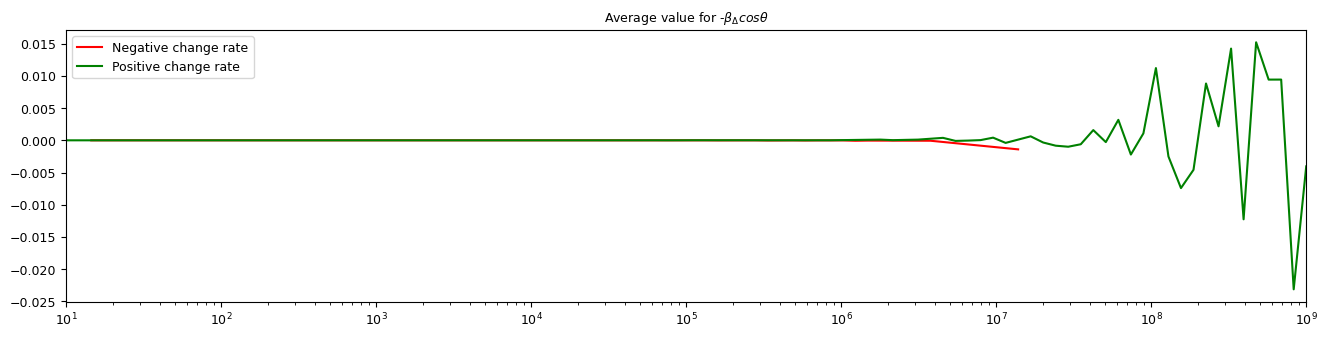

In [196]:
res_pos = []
res_neg = []
fig = plt.figure(figsize = (16,12))
ax1 = fig.add_subplot(311)
for idx1 in range(len(costhetas_neg[0,:])):
    gme0 = gmes_neg[idx1]
    costhetas_idx = costhetas_neg[:,idx1]
    res_neg.append(np.mean(-costhetas_idx*dbeta_neg[:,idx1]))
    #alphas_idx = alphas_neg[:,idx1]
    #phis_idx = phis_neg[:,idx1]
ax1.plot(gmes_neg, res_neg,color = 'r', label = 'Negative change rate')
for idx2 in range(len(costhetas_pos[0,:])):
    gme0 = gmes_pos[idx2]
    costhetas_idx = costhetas_pos[:,idx2]
    res_pos.append(np.mean(-costhetas_idx*dbeta_pos[:,idx2]))
    #alphas_idx = alphas_pos[:,idx1]
    #phis_idx = phis_pos[:,idx1]
ax1.plot(gmes_pos, res_pos ,color = 'g', label = 'Positive change rate')
#ax1.hlines(0.0,1e1,1e9, linestyles='--')
ax1.set_xlim(1e1,1e9)
#ax1.set_ylim(-1e-8,1e-8)
ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_title(r'Average value for -$\beta_{\Delta} cos \theta$')
#ax1.set_xlabel(r'$\gamma$')
ax1.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


20
22


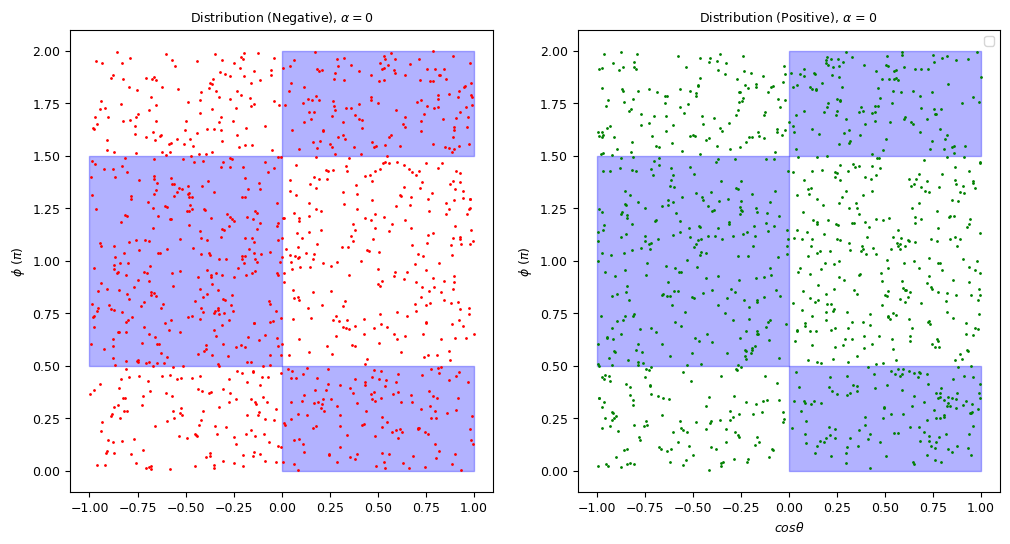

In [197]:
#粒子在costheta - phi平面上的分布
#print(neg_idx)
#print(pos_idx)
idx_trial_neg = neg_idx[10]
idx_trial_pos = pos_idx[10]
print(idx_trial_neg)
print(idx_trial_pos)

dbeta_neg = beta_Ds[:,idx_trial_neg] # 负变化率
dbeta_pos = beta_Ds[:,idx_trial_pos] # 正变化率
phi_neg = phis_pros[:,idx_trial_neg]/(np.pi)
phi_pos = phis_pros[:,idx_trial_pos]/(np.pi)
costheta_neg = costhetas[:,idx_trial_neg]
costheta_pos = costhetas[:, idx_trial_pos]

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax1.set_title(r'Distribution (Negative), $\alpha = 0$')
ax1.scatter(costheta_neg, phi_neg,s=1, color = 'r')
# 有效加速区域
ax1.fill_betweenx([1.5, 2],     
                  0, 1,          
                  color='blue', alpha=0.3, zorder=0) 
ax1.fill_betweenx([0.5, 1.5],     
                  -1, 0,          
                  color='blue', alpha=0.3, zorder=0) 
ax1.fill_betweenx([0, 0.5],     
                  0, 1,          
                  color='blue', alpha=0.3, zorder=0) 
#ax1.set_xlabel(r'$cos \theta$')
ax1.set_ylabel(r'$\phi$ ($\pi$)')

ax2 = fig.add_subplot(122)
ax2.set_title(r'Distribution (Positive), $\alpha$ = 0')
ax2.scatter(costheta_pos, phi_pos,s=1, color = 'g')
# 有效加速区域
ax2.fill_betweenx([1.5, 2],     
                  0, 1,          
                  color='blue', alpha=0.3, zorder=0) 
ax2.fill_betweenx([0.5, 1.5],     
                  -1, 0,          
                  color='blue', alpha=0.3, zorder=0) 
ax2.fill_betweenx([0, 0.5],     
                  0, 1,          
                  color='blue', alpha=0.3, zorder=0) 
ax2.set_xlabel(r'$cos \theta$')
ax2.set_ylabel(r'$\phi$ ($\pi$)')
ax2.legend()

plt.show()